# Code

In [14]:
%matplotlib inline

import gym
import itertools
import matplotlib
import matplotlib.pyplot as pltimport 
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import numpy as np
import sklearn.pipeline
import sklearn.preprocessing
from sklearn.kernel_approximation import RBFSampler
from collections import defaultdict
import scipy
from q_learning import *


In [15]:
def normalization(env, observation_examples):
    """
    Standardizes state observations by calculating their mean and variance.

    Args:
        env: Gym environment (used for consistency, though not directly required here).
        observation_examples: An array of random state observations sampled from the environment.

    Returns:
        sklearn.preprocessing.StandardScaler: A scaler fitted to the observations.
    """
    # Ensure the input is a 2D array
    observation_examples = np.array(observation_examples).reshape(-1, env.observation_space.shape[0])
    
    # Fit a scaler to normalize the data
    scaler = sklearn.preprocessing.StandardScaler()
    scaler.fit(observation_examples)
    
    return scaler


In [16]:
def featurizer_function(normalized_data, featureVecDim):
    """
    Generates a feature transformation pipeline using radial basis function (RBF) kernels.

    Args:
        normalized_data: An array of normalized state observations.
        featureVecDim: Target dimensionality for the feature transformation.

    Returns:
        sklearn.pipeline.FeatureUnion: A pipeline that transforms data into feature vectors.
    """
    # Create an RBF-based featurizer with multiple scales
    featurizer_vector = sklearn.pipeline.FeatureUnion([
        ("rbf1", RBFSampler(gamma=0.5, n_components=featureVecDim // 3)),
        ("rbf2", RBFSampler(gamma=0.25, n_components=featureVecDim // 3)),
        ("rbf3", RBFSampler(gamma=0.1, n_components=featureVecDim - 2 * (featureVecDim // 3)))
    ])
    
    # Ensure the normalized_data is a 2D array
    normalized_data = np.array(normalized_data).reshape(-1, normalized_data.shape[1])
    
    # Fit the featurizer to the normalized position data
    featurizer_vector.fit(normalized_data)
    
    return featurizer_vector

In [17]:
def scaler_val(state, scaler):
    # Chuẩn hóa toàn bộ vector trạng thái
    normalized_state = (state - scaler.mean_) / scaler.var_
    return normalized_state


In [18]:
def UniformRandomPolicyGenerator(nA):
    # nA = number of actions
    def urpg(state):
        return np.ones(nA, dtype=float)/nA
    return urpg

In [19]:
def RandomVectorGenerator(featureVecDim):
    return 2*np.random.rand(featureVecDim)-1

In [20]:
def max_dict(dictionary):
    v_max=max(dictionary.values())
    for key, value in dictionary.items():
        if value == v_max:
            return key

In [21]:
def e_greedy_policy(estimator, nA,epsilon):
    def policy_maker(observation):
        A=np.ones(nA, dtype=float)*epsilon/nA
        q_values=  estimator.predict(observation)
        best_action=np.argmax(q_values)
        A[best_action] += (1.0-epsilon)
        return A
    return policy_maker

In [22]:
def reward(alpha_vec, featurizer_vector, scaler):
    def reward_fn(state):
        normalized_state = scaler.transform(np.array(state).reshape(1, -1))

        # Áp dụng featurizer_vector trên state đã được chuẩn hóa
        features = featurizer_vector.transform(normalized_state)

        # Tính giá trị thưởng bằng dot product giữa alpha_vec và các đặc trưng
        return np.dot(alpha_vec, features[0])
    
    return reward_fn


In [23]:
def reward_plot(alpha_vec, featurizer_vector, scaler):
    x = np.linspace(-np.pi, np.pi, 1000)
    y = np.zeros(1000)
    i = 0

    for position in x:
        state = np.array([position, 0, 0, 0, 0, 0])  

        scaled_state = (state - scaler.mean_) / scaler.var_
        scaled_state = scaled_state.reshape(1, -1) 

        transformed_state = featurizer_vector.transform(scaled_state)

        y[i] = np.dot(alpha_vec, transformed_state[0])
        i += 1

    plt.plot(x, y, linewidth=2.0)
    plt.title("Reward Function")
    plt.xlabel("State (Position)")
    plt.ylabel("Reward")
    plt.savefig("acrobot_videos\\reward_function.png", dpi=300, bbox_inches='tight')
    plt.show()


In [24]:
def ValueFunctionGenerator(env, alpha_vec, policy, featurizer_vec, scaler, featureVecDim, num_trajectories, discount_factor):
    """
    Calculates the value and value vector of the start state: V(s0).
    """
    v_basis = np.zeros(featureVecDim)
    episode = defaultdict(list) 
    for i in range(num_trajectories):
        state = env.reset()
        done = False
        for _ in range(200):    
            prob = policy(state)
            action = np.random.choice(np.arange(len(prob)), p=prob)
            new_observations = env.step(action)
            next_state = new_observations[0]
            done = new_observations[2]
            if done:
                break
            episode[i].append((state, action))
            state = next_state
        
        j = 0
        for state, action in episode[i]:
            scaled_state = scaler_val(state, scaler)
            # Đảm bảo scaled_state là mảng 2D
            scaled_state = np.array(scaled_state).reshape(1, -1)

            # scaled_state = np.atleast_2d(scaled_state)
            
            # transformed_state = featurizer_vec.transform(scaled_state)
            scaled_state = scaler_val(state, scaler)
            scaled_state = np.array(scaled_state).reshape(1, -1)  # Đảm bảo 2D array
            transformed_state = featurizer_vec.transform(scaled_state)

            
            v_basis += transformed_state[0] * (discount_factor)**j
            j += 1

    v_basis_net = v_basis / num_trajectories
    V = np.dot(alpha_vec, v_basis_net)
    return V, v_basis_net


In [25]:
def irl(env, alpha_vec,featurizer_vector, scaler, featurizer, normalized_data, featureVecDim, policy_dbe,num_trajectories=200, num_episodes=100, max_epoch=10, discount_factor=1, penalty_factor=2, epsilon_v=0.0):
    """
    The algorithm to learn a reward function given expert policy/trajectories.
    
    Args:
        env: Gym environment
        alpha_vec: The alpha vector (variable) to be learnt.
        featurizer_vector: The container for basis fuctions(RBF kernals in this case).
        scaler: Mean and variance of the state values.
        featurizer: The container used for generating expert trajectories.
        normalized_data: An array of 10000 normalized state::[position, velocity] values.
        featureVecDim: Dimension of ϕ vector.(feature vector/Basis vector)
        policy_dbe: "Demostration by expert" policy.==Expert policy
        num_trajectories: Expert trajectories taken under consideration
        num_episodes: Number of episodes for which the RL code is run. 
        max_iter: Maximum number of episodes
        penalty_factor: Refer the paper for more details
        epsilon_v: ϵ value for Epsilon greedy policy
        
    Returns:
        Reward Function R(s).
        Alpha Vector: α = [α0 α1 .. αn]
    """
    # Initializing Variables
    nP=0                                    # number of epochs
    V_vec = defaultdict(float)
    V_policy_basis = defaultdict(list)
    V_input = np.zeros(featureVecDim)
    
    # Calculating V* value for the best DBE policy that we already have.
    V_dbe, V_dbe_basis = ValueFunctionGenerator(env,alpha_vec, policy_dbe,featurizer_vector,scaler,featureVecDim, num_trajectories, discount_factor)
    print("-------------------------------")
    print("| V_dbe | ",V_dbe," |")
    print("-------------------------------")
    print("")
    
    # Iterating part of the code : new learnt policy with each new iteration
    
    while True:
        print("############################################################################")
        print("Starting epoch {} .... ".format(nP))
        print("Alpha_vec value at the start of the epoch = {}".format(alpha_vec)) 
        
        # Uniform Random policy
        if nP ==0:
            policy_ = UniformRandomPolicyGenerator(env.action_space.n)
        
        V_vec[nP], V_policy_basis[nP] = ValueFunctionGenerator(env,alpha_vec, policy_,featurizer_vector,scaler,featureVecDim,num_trajectories, discount_factor)
        print("New policy value based on previous alpha, V_vec[np] = {}".format(V_vec[nP]))
    
    
        # Linear Programming optimization
        print("_____________________________LP starts_______________________________")
        
        # nP_best: Iteration with the max value according to the present alpha_vec.
        nP_best = max_dict(V_vec)
        
        print("nP_best =", nP_best)
        print("nP_best_value based on old alpha =", V_vec[nP_best])
        print("DBE_value based on old alpha =", V_dbe)
        
        # if V_dbe - V_vec[nP] >= 0:
        #     V_input += V_policy_basis[nP] - V_dbe_basis
        # else:
        #     V_input += penalty_factor* (V_policy_basis[nP] - V_dbe_basis)
        
        # res = scipy.optimize.linprog(V_input, bounds=(-1,1), method="simplex")
        
        
        if V_dbe - V_vec[nP] >= 0:
            V_input += V_policy_basis[nP] - V_dbe_basis
        else:
            V_input += penalty_factor * (V_policy_basis[nP] - V_dbe_basis)

        # Duy trì V_input trong đúng bounds
        res = scipy.optimize.linprog(V_input, bounds=[(-1, 1)] * featureVecDim, method="simplex")

        
        print("**********LP results******************************************************")
        print("                       ")
        #print(res)
        print("new alpha_vec = ", res.x)
        print("                       ")
        print("**************************************************************************")
        
        alpha_vec_new = res.x
        
        # New V-dbe value based on new alpha
        V_dbe_new = np.dot(alpha_vec_new,V_dbe_basis)
        
        # Updating old values with new values
        alpha_vec = alpha_vec_new
        V_dbe = V_dbe_new
        
        # Editing v_vec values based on new alpha
        for i,list_ in V_policy_basis.items():
            V_vec[i] = np.dot(list_,alpha_vec)
        
        print("According to new alpha, V_dbe = ", V_dbe_new)
        print("New V_vec[max] in existing values", V_vec[max_dict(V_vec)])
        print("_________________________________________________________________________")
        print("Plotting reward function based on alpha_vec start value.....")
        
        reward_plot(alpha_vec, featurizer_vector,scaler)

        # Reinforcement learning using the learnt reward function to generate new policy
        
        print("Q learning starts..........")
        # Given the new alpha_vec, update the rewards function and find a new policy
        reward_fn = reward(alpha_vec,featurizer_vector,scaler)
        nP +=1
        
        estimator = Estimator(env,scaler,featurizer)
        min_iter_length = q_learning(env, estimator, reward_fn, num_episodes,print_ep_details=False) 
        policy_ = e_greedy_policy(estimator, env.action_space.n,epsilon_v)
        """
        ** For printing iterations with number of timesteps it took, set 
        {print_ep_details=True} in q_learning().Highly Suggested for starting analysis.
        """
    
        if nP > max_epoch:
            break
        print("############################################################################")
    
    
    return reward_fn, alpha_vec

100%|██████████| 1000/1000 [05:58<00:00,  2.79it/s]


___Plotting Learning Stats of the Agent____


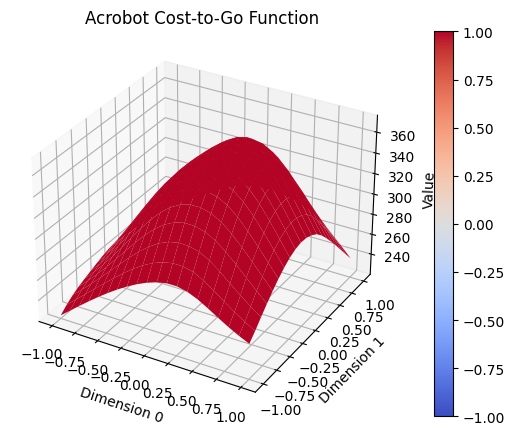

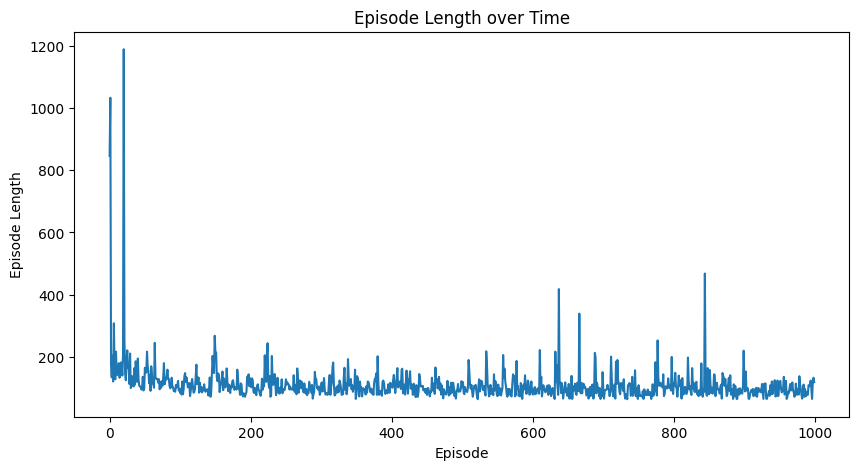

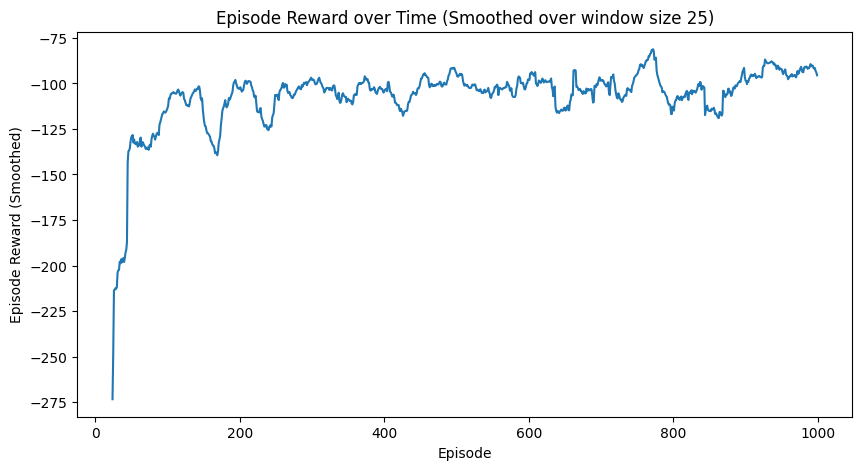

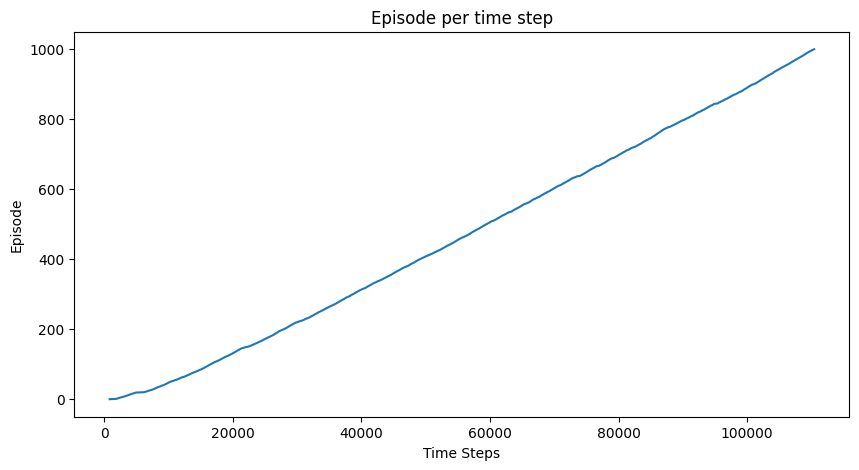

In [26]:
import gym
env = gym.make("Acrobot-v1").env  

# Global_variables
featureVecDim= 500

observation_examples = np.array([env.observation_space.sample() for _ in range(10000)])
scaler = normalization(env, observation_examples)
normalized_data = scaler.transform(observation_examples)
os.makedirs('acrobot_videos', exist_ok=True)
# Tạo featurizer
featurizer = featurizer_function(normalized_data, featureVecDim)

policy_dbe, estimator_dbe = policy_f(env, scaler, featurizer, print_ep_lens=False)


In [27]:
# Basis functions Container / Feature Vector Container
featurizer_vector = featurizer_function(normalized_data, featureVecDim)
alpha_vec = RandomVectorGenerator(featureVecDim)

-------------------------------
| V_dbe |  -30.772043756451424  |
-------------------------------

############################################################################
Starting epoch 0 .... 
Alpha_vec value at the start of the epoch = [-0.69409261  0.99193657  0.56145601  0.77490605 -0.05642683  0.44142452
  0.90610197  0.42523009  0.71660956 -0.65295044  0.32261026 -0.49671817
 -0.26695126 -0.38981969 -0.53350656  0.17095261 -0.00336854 -0.65471461
  0.07559419 -0.15328746 -0.84466453 -0.73488122  0.26716209  0.61919533
 -0.24217409 -0.82868757  0.59765449 -0.19794971 -0.38290737  0.55641798
  0.37553599 -0.82991552 -0.15839969 -0.56274238 -0.70635194 -0.49524628
 -0.54192705  0.92883842 -0.5668442   0.00433355  0.09777892  0.02425514
 -0.58745099  0.53418504 -0.63951683 -0.46529195 -0.53900378  0.84275342
  0.92848798  0.86678989 -0.15172747  0.65173412 -0.43464337  0.1847438
 -0.1026872   0.74210576 -0.7783923   0.07975575 -0.81383261 -0.40636633
  0.41654499  0.28965951 -0.

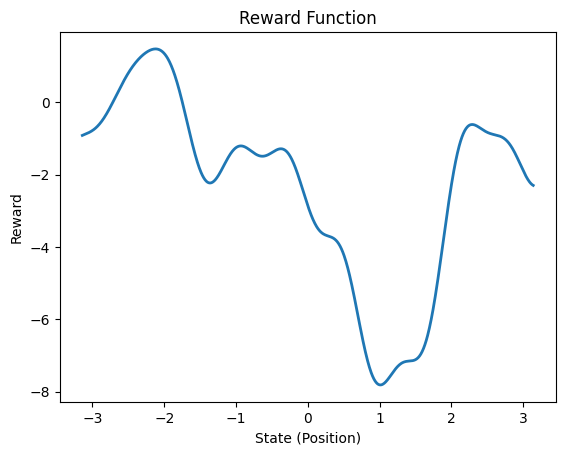

Q learning starts..........


100%|██████████| 100/100 [00:54<00:00,  1.84it/s]


############################################################################
############################################################################
Starting epoch 1 .... 
Alpha_vec value at the start of the epoch = [-1. -1. -1. -1.  1. -1. -1.  1.  1.  1.  1. -1. -1.  1. -1. -1.  1.  1.
 -1.  1. -1. -1.  1. -1.  1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1. -1.  1.  1. -1. -1.  1. -1. -1.  1.  1. -1. -1. -1.  1. -1.  1. -1.
 -1. -1. -1.  1.  1.  1.  1. -1.  1. -1. -1. -1.  1.  1.  1.  1. -1.  1.
 -1.  1. -1. -1.  1. -1.  1.  1. -1.  1.  1.  1.  1. -1.  1.  1. -1. -1.
  1.  1.  1.  1. -1.  1.  1. -1. -1.  1. -1. -1.  1. -1. -1.  1. -1.  1.
 -1.  1. -1.  1.  1. -1. -1. -1.  1.  1. -1.  1. -1.  1.  1. -1. -1.  1.
 -1. -1. -1. -1. -1.  1.  1.  1. -1.  1. -1. -1. -1. -1.  1. -1.  1. -1.
 -1.  1. -1. -1.  1. -1.  1.  1. -1. -1. -1.  1.  1.  1. -1.  1. -1.  1.
  1. -1.  1. -1. -1. -1. -1.  1.  1. -1. -1. -1. -1.  1.  1.  1. -1. -1.
 -1. -1.  1.  1. -1. -1.  1.  1.  1. -1.  1.  1. 

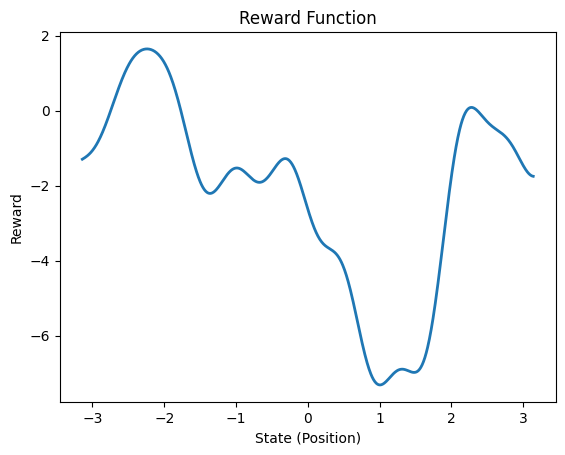

Q learning starts..........


100%|██████████| 100/100 [00:50<00:00,  2.00it/s]


############################################################################
############################################################################
Starting epoch 2 .... 
Alpha_vec value at the start of the epoch = [-1. -1. -1. -1.  1. -1. -1.  1.  1.  1.  1. -1. -1.  1. -1. -1.  1.  1.
 -1.  1. -1. -1.  1. -1.  1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1. -1.  1. -1. -1. -1.  1. -1. -1.  1.  1. -1. -1. -1.  1. -1.  1. -1.
 -1. -1. -1.  1.  1.  1.  1. -1.  1. -1. -1. -1.  1.  1.  1.  1. -1.  1.
 -1.  1. -1. -1.  1. -1.  1.  1. -1. -1.  1.  1.  1. -1.  1.  1. -1. -1.
  1.  1.  1.  1. -1.  1.  1. -1. -1.  1. -1. -1. -1. -1. -1.  1. -1.  1.
 -1.  1. -1.  1.  1. -1. -1. -1.  1.  1. -1.  1. -1.  1.  1. -1. -1.  1.
 -1. -1. -1. -1. -1.  1.  1.  1. -1.  1. -1. -1. -1. -1.  1. -1.  1. -1.
 -1.  1. -1. -1.  1. -1.  1.  1. -1. -1. -1.  1.  1.  1. -1.  1. -1.  1.
  1. -1.  1. -1. -1. -1.  1.  1.  1. -1. -1. -1. -1.  1.  1.  1. -1. -1.
 -1. -1.  1.  1. -1. -1.  1.  1.  1. -1.  1.  1. 

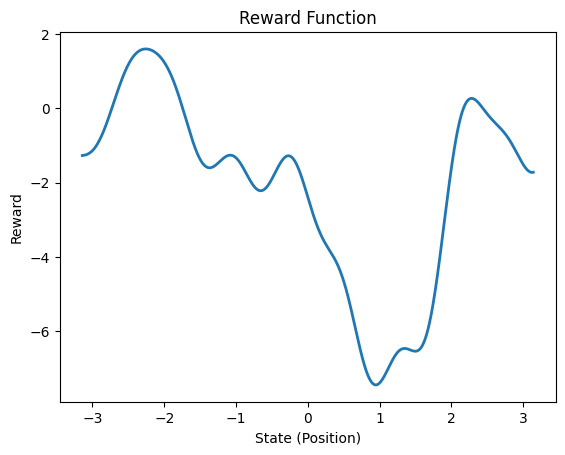

Q learning starts..........


100%|██████████| 100/100 [00:52<00:00,  1.90it/s]


############################################################################
############################################################################
Starting epoch 3 .... 
Alpha_vec value at the start of the epoch = [ 1. -1. -1. -1.  1. -1. -1.  1.  1.  1.  1. -1. -1.  1. -1. -1.  1.  1.
 -1.  1. -1. -1. -1. -1.  1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1. -1.  1. -1. -1. -1.  1. -1. -1.  1.  1. -1. -1. -1.  1. -1.  1. -1.
 -1. -1. -1.  1.  1.  1.  1. -1.  1. -1. -1. -1.  1.  1.  1.  1. -1.  1.
 -1.  1. -1. -1.  1. -1.  1.  1. -1. -1.  1.  1.  1. -1.  1.  1. -1. -1.
  1.  1.  1.  1. -1.  1.  1. -1. -1.  1. -1. -1. -1. -1. -1.  1. -1.  1.
 -1.  1. -1.  1.  1. -1. -1. -1.  1.  1. -1.  1. -1.  1.  1. -1. -1.  1.
 -1. -1. -1. -1. -1.  1.  1.  1. -1.  1. -1. -1. -1. -1.  1. -1.  1. -1.
 -1.  1. -1. -1.  1. -1.  1.  1. -1. -1. -1.  1.  1.  1. -1.  1. -1.  1.
  1. -1.  1. -1. -1. -1.  1.  1.  1. -1. -1. -1. -1. -1.  1.  1. -1. -1.
 -1. -1.  1.  1. -1. -1.  1.  1.  1. -1.  1.  1. 

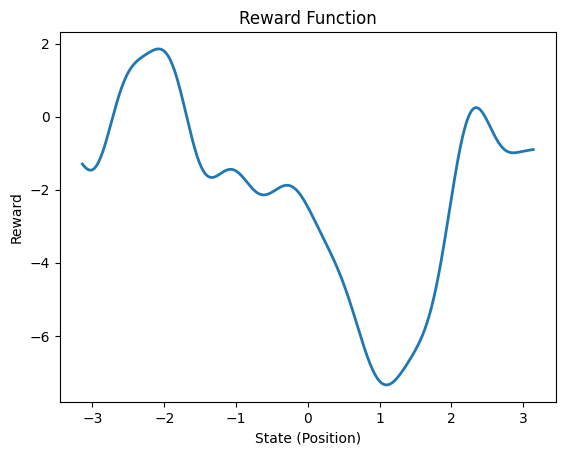

Q learning starts..........


100%|██████████| 100/100 [01:20<00:00,  1.24it/s]


############################################################################
############################################################################
Starting epoch 4 .... 
Alpha_vec value at the start of the epoch = [ 1. -1. -1. -1.  1. -1. -1.  1.  1.  1.  1. -1. -1.  1. -1. -1.  1. -1.
 -1.  1. -1. -1. -1. -1.  1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1. -1.  1. -1. -1. -1.  1. -1. -1.  1.  1. -1. -1. -1.  1. -1.  1. -1.
 -1. -1. -1.  1.  1.  1.  1. -1.  1. -1. -1. -1.  1.  1.  1.  1. -1.  1.
 -1.  1. -1. -1.  1. -1.  1.  1. -1. -1.  1.  1.  1. -1.  1.  1. -1. -1.
  1.  1.  1.  1. -1.  1.  1. -1. -1.  1. -1. -1. -1. -1. -1.  1. -1.  1.
 -1. -1. -1.  1.  1. -1. -1. -1.  1.  1. -1.  1. -1.  1.  1. -1. -1.  1.
 -1. -1. -1. -1. -1.  1.  1.  1. -1.  1. -1. -1. -1. -1.  1. -1.  1. -1.
 -1.  1. -1. -1.  1. -1.  1.  1. -1. -1. -1.  1.  1.  1. -1.  1.  1.  1.
  1. -1.  1. -1. -1. -1.  1.  1.  1. -1. -1. -1. -1. -1.  1.  1. -1. -1.
 -1. -1.  1.  1. -1. -1.  1.  1.  1. -1.  1.  1. 

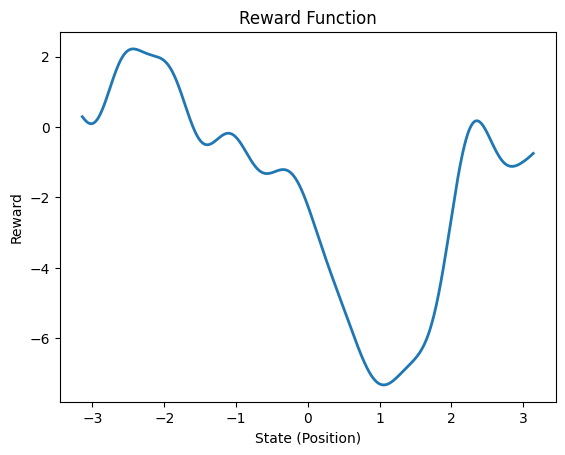

Q learning starts..........


100%|██████████| 100/100 [00:52<00:00,  1.92it/s]


############################################################################
############################################################################
Starting epoch 5 .... 
Alpha_vec value at the start of the epoch = [-1. -1. -1. -1.  1. -1. -1.  1.  1.  1.  1. -1. -1.  1.  1. -1. -1. -1.
 -1.  1. -1. -1. -1. -1.  1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1. -1.  1. -1.  1. -1.  1. -1.  1.  1.  1. -1. -1. -1.  1. -1.  1. -1.
 -1. -1. -1.  1. -1.  1.  1. -1. -1.  1. -1. -1.  1.  1.  1.  1. -1.  1.
 -1.  1. -1. -1.  1. -1.  1.  1. -1. -1.  1.  1.  1. -1.  1.  1. -1. -1.
  1.  1.  1.  1. -1.  1.  1. -1. -1.  1. -1. -1.  1. -1. -1.  1. -1.  1.
 -1.  1. -1.  1.  1. -1. -1. -1.  1.  1. -1.  1. -1.  1.  1. -1. -1.  1.
 -1. -1. -1. -1. -1.  1.  1.  1. -1.  1. -1. -1. -1. -1.  1. -1.  1. -1.
 -1.  1. -1. -1.  1. -1.  1.  1. -1. -1. -1.  1. -1.  1. -1.  1.  1.  1.
  1. -1.  1. -1. -1. -1. -1.  1.  1. -1. -1. -1. -1. -1.  1.  1. -1. -1.
 -1. -1.  1.  1. -1. -1.  1.  1.  1. -1.  1.  1. 

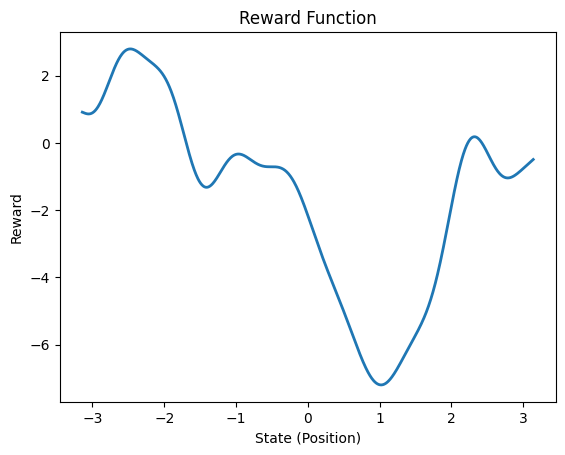

Q learning starts..........


100%|██████████| 100/100 [01:07<00:00,  1.48it/s]


############################################################################
############################################################################
Starting epoch 6 .... 
Alpha_vec value at the start of the epoch = [ 1.  1. -1. -1.  1. -1. -1.  1.  1.  1.  1. -1. -1.  1.  1. -1. -1. -1.
 -1.  1. -1. -1. -1. -1.  1.  1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1. -1.  1. -1.  1. -1.  1. -1.  1.  1.  1. -1. -1. -1.  1. -1.  1. -1.
 -1. -1. -1.  1. -1.  1.  1. -1. -1.  1. -1. -1.  1.  1.  1.  1. -1.  1.
 -1.  1. -1. -1.  1. -1.  1.  1. -1. -1.  1.  1.  1. -1.  1.  1. -1. -1.
  1.  1.  1.  1. -1.  1.  1. -1. -1.  1. -1. -1. -1. -1. -1.  1. -1.  1.
 -1.  1. -1.  1.  1. -1. -1. -1.  1.  1. -1.  1. -1.  1.  1. -1. -1.  1.
 -1. -1. -1. -1. -1.  1.  1.  1. -1.  1. -1. -1. -1. -1.  1. -1.  1. -1.
 -1. -1. -1. -1.  1. -1.  1. -1. -1. -1. -1.  1. -1.  1. -1.  1.  1.  1.
  1.  1.  1. -1. -1. -1.  1.  1.  1. -1. -1. -1. -1. -1.  1.  1. -1. -1.
 -1. -1.  1.  1. -1. -1.  1.  1.  1. -1.  1.  1. 

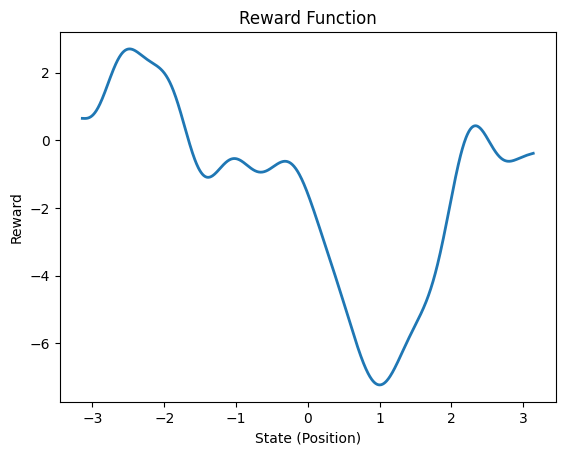

Q learning starts..........


100%|██████████| 100/100 [00:56<00:00,  1.78it/s]


############################################################################
############################################################################
Starting epoch 7 .... 
Alpha_vec value at the start of the epoch = [ 1.  1. -1. -1.  1. -1. -1.  1.  1.  1.  1. -1. -1.  1.  1. -1. -1. -1.
 -1.  1. -1. -1. -1. -1.  1.  1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1. -1.  1. -1.  1. -1. -1. -1.  1.  1.  1. -1. -1. -1.  1. -1.  1. -1.
 -1. -1. -1.  1. -1.  1.  1. -1. -1.  1. -1. -1.  1.  1.  1.  1. -1.  1.
 -1.  1. -1. -1.  1. -1.  1.  1. -1. -1.  1.  1.  1. -1.  1.  1. -1. -1.
  1.  1.  1.  1. -1.  1.  1. -1. -1.  1. -1. -1. -1. -1. -1.  1. -1.  1.
 -1.  1. -1.  1.  1. -1. -1. -1.  1.  1. -1.  1. -1.  1.  1. -1. -1.  1.
 -1. -1. -1. -1. -1.  1.  1.  1. -1.  1. -1. -1. -1. -1.  1. -1.  1. -1.
 -1. -1. -1. -1.  1. -1.  1. -1. -1. -1. -1.  1. -1.  1. -1.  1.  1.  1.
  1.  1.  1. -1. -1. -1.  1. -1.  1. -1. -1. -1. -1. -1.  1.  1. -1. -1.
 -1. -1.  1.  1. -1. -1.  1.  1.  1. -1.  1.  1. 

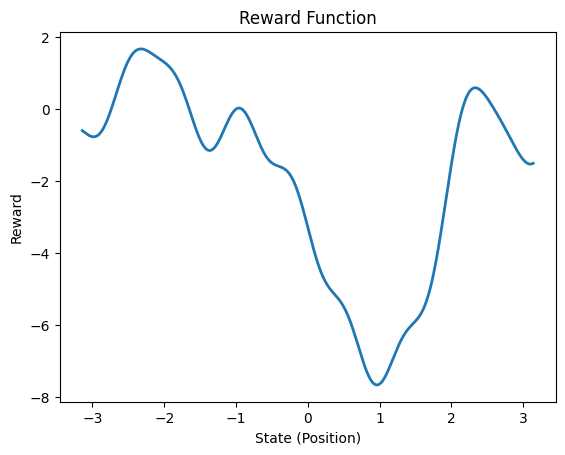

Q learning starts..........


100%|██████████| 100/100 [01:17<00:00,  1.29it/s]


############################################################################
############################################################################
Starting epoch 8 .... 
Alpha_vec value at the start of the epoch = [-1.  1. -1. -1.  1. -1. -1.  1.  1.  1.  1. -1. -1.  1. -1. -1.  1. -1.
 -1.  1. -1. -1. -1. -1.  1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1. -1. -1.  1. -1. -1.  1. -1. -1.  1.  1. -1. -1. -1.  1. -1.  1. -1.
 -1. -1. -1.  1.  1.  1.  1. -1.  1. -1. -1. -1.  1.  1.  1.  1. -1.  1.
 -1.  1. -1. -1.  1. -1.  1.  1. -1.  1.  1.  1.  1. -1.  1.  1. -1. -1.
 -1.  1.  1.  1. -1.  1.  1. -1. -1.  1. -1. -1. -1. -1. -1.  1. -1.  1.
 -1.  1. -1.  1. -1. -1. -1. -1.  1.  1. -1.  1. -1.  1.  1. -1. -1.  1.
 -1. -1. -1. -1. -1.  1.  1.  1. -1.  1. -1. -1. -1. -1.  1. -1.  1. -1.
 -1.  1.  1. -1.  1. -1.  1.  1. -1. -1. -1.  1.  1.  1. -1.  1.  1.  1.
  1. -1.  1. -1. -1. -1. -1.  1.  1. -1. -1. -1. -1. -1.  1.  1. -1. -1.
 -1. -1.  1.  1. -1. -1.  1.  1.  1. -1.  1.  1. 

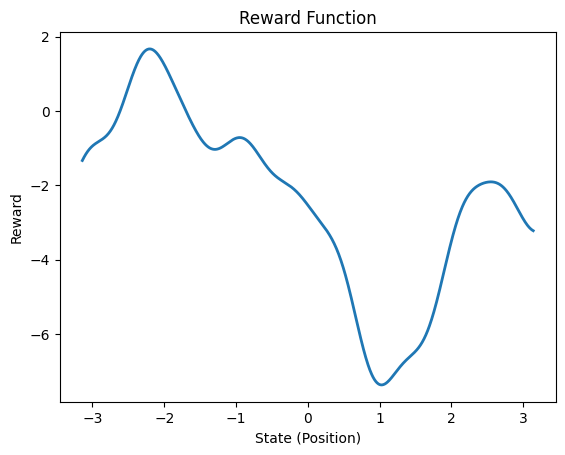

Q learning starts..........


100%|██████████| 100/100 [01:20<00:00,  1.25it/s]


############################################################################
############################################################################
Starting epoch 9 .... 
Alpha_vec value at the start of the epoch = [-1. -1. -1. -1.  1. -1. -1.  1.  1.  1.  1. -1. -1.  1. -1. -1.  1.  1.
 -1.  1. -1. -1.  1. -1.  1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1. -1. -1.  1. -1. -1.  1. -1. -1.  1.  1. -1. -1. -1.  1. -1.  1.  1.
  1. -1.  1.  1.  1.  1.  1. -1.  1. -1.  1. -1.  1.  1.  1.  1. -1.  1.
 -1.  1. -1. -1. -1. -1.  1.  1. -1.  1.  1.  1.  1. -1.  1.  1. -1. -1.
 -1.  1.  1.  1. -1.  1.  1. -1. -1. -1.  1. -1.  1. -1. -1.  1. -1.  1.
 -1.  1. -1.  1. -1. -1.  1. -1. -1.  1. -1.  1. -1.  1.  1.  1. -1. -1.
 -1. -1. -1. -1. -1.  1.  1.  1. -1.  1. -1. -1. -1. -1. -1. -1.  1. -1.
  1.  1.  1. -1.  1. -1.  1.  1. -1.  1.  1.  1.  1.  1. -1.  1. -1.  1.
  1. -1.  1. -1. -1. -1. -1.  1.  1. -1. -1. -1. -1.  1.  1.  1. -1. -1.
 -1. -1.  1.  1. -1. -1.  1.  1.  1. -1.  1.  1. 

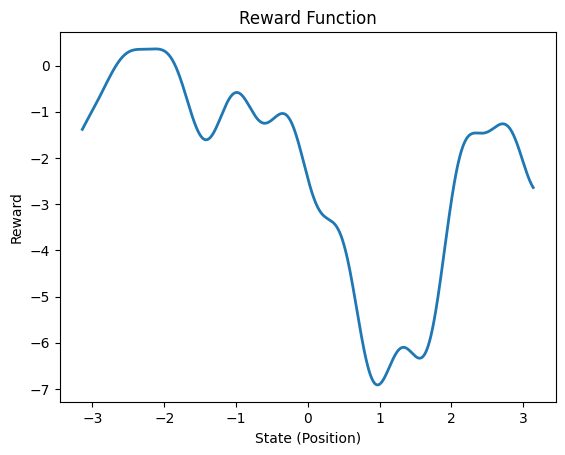

Q learning starts..........


100%|██████████| 100/100 [00:50<00:00,  1.97it/s]


############################################################################
############################################################################
Starting epoch 10 .... 
Alpha_vec value at the start of the epoch = [-1. -1. -1. -1.  1. -1. -1.  1.  1.  1.  1. -1. -1.  1. -1. -1.  1.  1.
 -1.  1. -1. -1.  1. -1.  1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1. -1. -1.  1. -1. -1.  1. -1. -1.  1.  1. -1. -1. -1.  1. -1.  1. -1.
  1. -1.  1.  1.  1.  1.  1. -1.  1. -1.  1. -1.  1.  1.  1.  1. -1.  1.
 -1.  1. -1. -1. -1. -1.  1.  1. -1.  1. -1.  1.  1. -1.  1.  1. -1. -1.
 -1.  1.  1.  1. -1.  1.  1. -1. -1. -1. -1. -1.  1. -1.  1.  1. -1.  1.
 -1.  1. -1.  1. -1. -1. -1. -1. -1.  1. -1.  1. -1.  1.  1.  1. -1. -1.
 -1. -1. -1. -1. -1.  1.  1.  1. -1.  1. -1. -1. -1. -1.  1. -1.  1. -1.
  1.  1.  1. -1.  1. -1.  1.  1. -1. -1.  1.  1.  1.  1. -1.  1. -1.  1.
  1. -1.  1. -1. -1. -1. -1.  1.  1. -1. -1. -1. -1.  1.  1.  1. -1. -1.
 -1. -1.  1.  1. -1. -1.  1.  1.  1. -1.  1.  1.

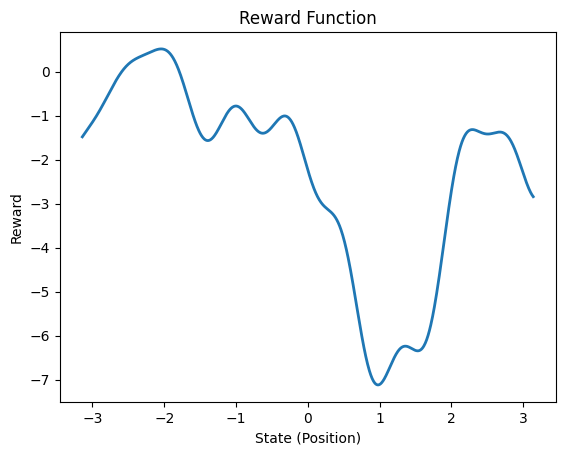

Q learning starts..........


100%|██████████| 100/100 [00:54<00:00,  1.82it/s]


In [28]:
reward_fn, alpha_vec = irl(env, alpha_vec, featurizer_vector, scaler, featurizer,
                           normalized_data, featureVecDim, policy_dbe)

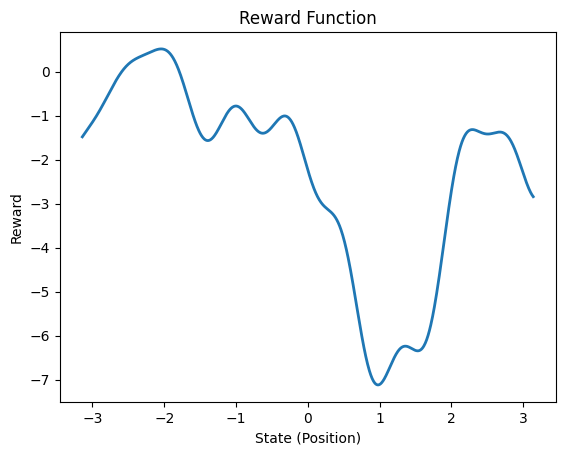

Q-learning starts:


100%|██████████| 200/200 [28:07<00:00,  8.44s/it]


Final results in graphs and 3D visualization:


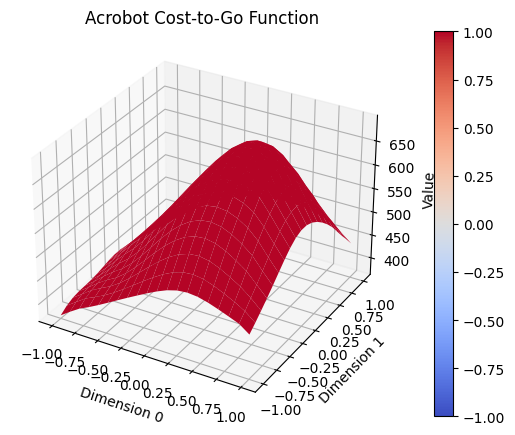

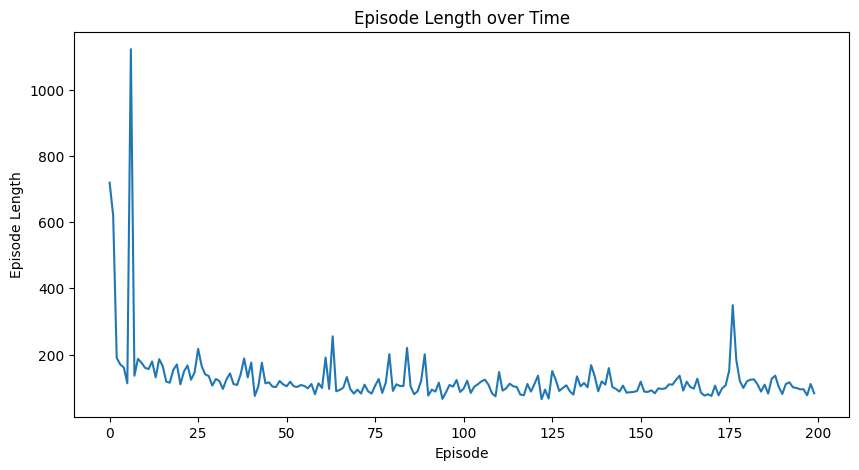

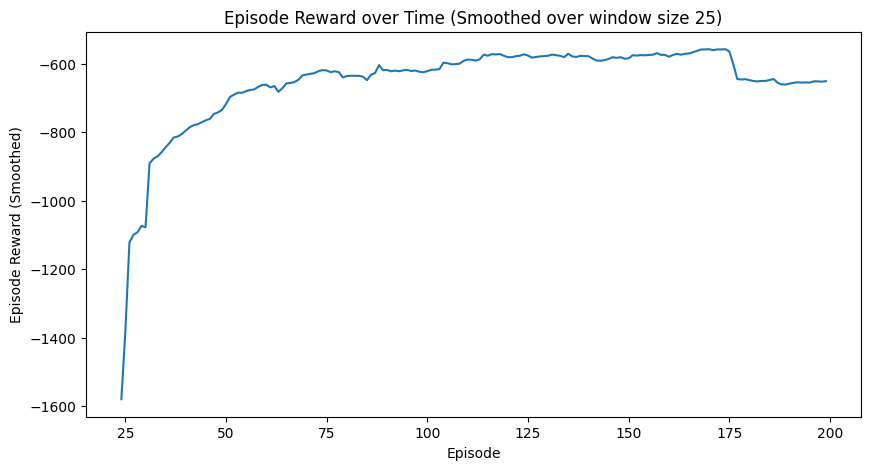

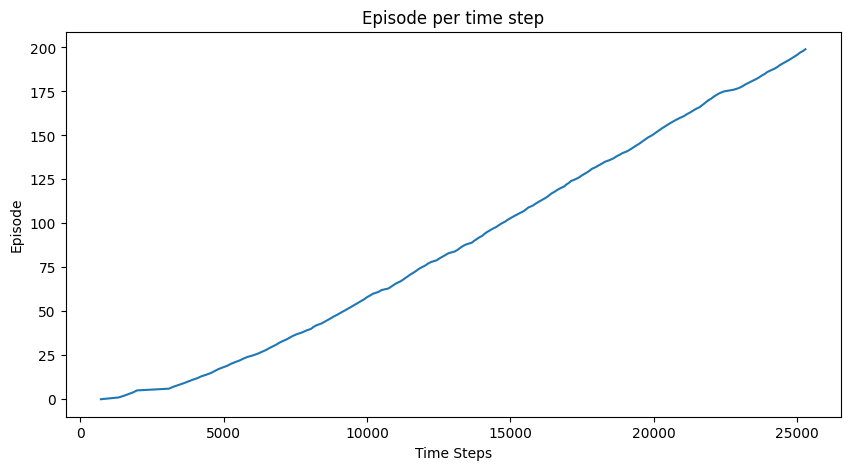

(<Figure size 1000x500 with 1 Axes>,
 <Figure size 1000x500 with 1 Axes>,
 <Figure size 1000x500 with 1 Axes>)

In [29]:
"""
Code Block generating stats for agent trained through learnt reward function.
"""
estimator_f = Estimator(env, scaler, featurizer)
reward_plot(alpha_vec,featurizer_vector,scaler)
print("Q-learning starts:")
"""
** For printing iterations with number of timesteps required, set {print_ep_details=True} in q_learning_testing_rewards().
Highly Suggested for starting analysis.
"""
success = q_learning_testing_rewards(env, estimator_f, reward_fn , num_episodes=200,render=True,ep_details=False)

print("Final results in graphs and 3D visualization:")
plotting.plot_cost_to_go_acrobot(env, estimator_f, scaler)
plotting.plot_episode_stats(success, smoothing_window=25)

100%|██████████| 100/100 [11:08<00:00,  6.69s/it]


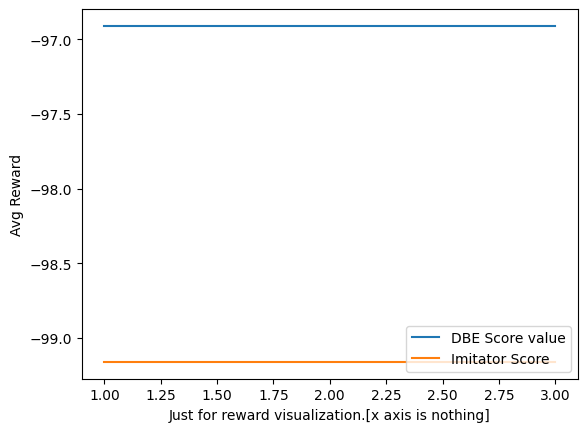

Expert policy score   |  -96.91
Imitator policy score |  -99.16


In [30]:
a,b = compare_results(env,estimator_f,estimator_dbe,num_test_trajs=100,epsilon_test=0.0)

In [31]:
from IPython.display import Video, display

# Hiển thị video trong notebook
video_path = "acrobot_videos\\rl-video-episode-90.mp4"
display(Video(video_path, embed=True, width=600, height=400))


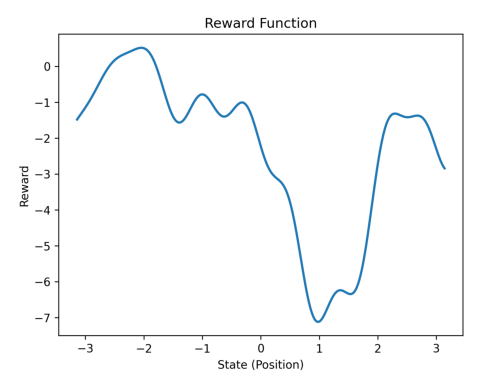

In [32]:
from PIL import Image

image_path = "acrobot_videos\\reward_function.png"
# Đọc ảnh từ đường dẫn
image = Image.open(image_path)

# Hiển thị ảnh
plt.imshow(image)
plt.axis('off')  # Tắt hiển thị trục
plt.show()
